In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from __future__ import print_function


In [7]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

G=nx.read_gml("dolphins.gml")
genero=ldata("dolphinsGender.txt")

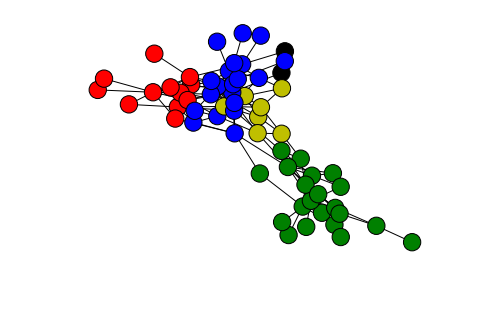

In [16]:
nx.draw(G,with_labels=False,node_color=[c[1] for c in F])
plt.show()

In [74]:
com = nx.algorithms.community.centrality.girvan_newman(G)
a=[nodos for nodos in com]
a

[({'Beak',
   'Bumper',
   'CCL',
   'Cross',
   'Double',
   'Fish',
   'Five',
   'Fork',
   'Grin',
   'Haecksel',
   'Hook',
   'Jonah',
   'Kringel',
   'MN105',
   'MN60',
   'MN83',
   'Oscar',
   'PL',
   'Patchback',
   'SMN5',
   'SN100',
   'SN4',
   'SN63',
   'SN9',
   'SN96',
   'Scabs',
   'Shmuddel',
   'Stripes',
   'TR120',
   'TR77',
   'TR88',
   'TR99',
   'TSN103',
   'TSN83',
   'Thumper',
   'Topless',
   'Trigger',
   'Vau',
   'Whitetip',
   'Zap',
   'Zipfel'},
  {'Beescratch',
   'DN16',
   'DN21',
   'DN63',
   'Feather',
   'Gallatin',
   'Jet',
   'Knit',
   'MN23',
   'Mus',
   'Notch',
   'Number1',
   'Quasi',
   'Ripplefluke',
   'SN89',
   'SN90',
   'TR82',
   'Upbang',
   'Wave',
   'Web',
   'Zig'}),
 ({'Beak',
   'Bumper',
   'CCL',
   'Cross',
   'Double',
   'Fish',
   'Five',
   'Fork',
   'Grin',
   'Haecksel',
   'Hook',
   'Jonah',
   'Kringel',
   'MN105',
   'MN60',
   'MN83',
   'Oscar',
   'PL',
   'Patchback',
   'SMN5',
   'SN100',
  

In [10]:
Cluster=[]
b=0
Color=["r","g","b","y","k"]
for c in a[3]:
    for n in a[3][b]:
        Cluster.append([n,Color[b]])
        
    b+=1


In [11]:
Cluster2=[]
b=0
Color=["r","g","b","y","k"]
for c in a[2]:
    for n in a[2][b]:
        Cluster2.append([n,Color[b]])
        
    b+=1
Cluster2

[['Haecksel', 'r'],
 ['TR99', 'r'],
 ['SN63', 'r'],
 ['Double', 'r'],
 ['Kringel', 'r'],
 ['Cross', 'r'],
 ['Thumper', 'r'],
 ['Stripes', 'r'],
 ['Whitetip', 'r'],
 ['TR120', 'r'],
 ['SN100', 'r'],
 ['Zap', 'r'],
 ['SN4', 'r'],
 ['Grin', 'r'],
 ['Five', 'r'],
 ['TSN103', 'r'],
 ['Jonah', 'r'],
 ['TR88', 'r'],
 ['Vau', 'r'],
 ['SN9', 'r'],
 ['Topless', 'r'],
 ['MN83', 'r'],
 ['Scabs', 'r'],
 ['Patchback', 'r'],
 ['SMN5', 'r'],
 ['MN105', 'r'],
 ['Shmuddel', 'r'],
 ['CCL', 'r'],
 ['Hook', 'r'],
 ['MN60', 'r'],
 ['Fork', 'r'],
 ['Trigger', 'r'],
 ['DN21', 'g'],
 ['Mus', 'g'],
 ['DN63', 'g'],
 ['Web', 'g'],
 ['Feather', 'g'],
 ['SN90', 'g'],
 ['Jet', 'g'],
 ['Upbang', 'g'],
 ['DN16', 'g'],
 ['Zig', 'g'],
 ['Beescratch', 'g'],
 ['Wave', 'g'],
 ['MN23', 'g'],
 ['TR82', 'g'],
 ['Knit', 'g'],
 ['SN89', 'g'],
 ['Quasi', 'g'],
 ['Ripplefluke', 'g'],
 ['Number1', 'g'],
 ['Notch', 'g'],
 ['Gallatin', 'g'],
 ['Oscar', 'b'],
 ['SN96', 'b'],
 ['Beak', 'b'],
 ['TR77', 'b'],
 ['Bumper', 'b'],
 ['Fish',

In [12]:
F=[]                    ##F va a ser el nuevo vector de nodo-genero pero ordenando los nodos de la misma manera que lo hace nx
for n in G.nodes():
    for k in Cluster:
        if k[0]==n:
            F.append([k[0],k[1]])

In [13]:
F

[['Haecksel', 'r'],
 ['DN21', 'g'],
 ['MN105', 'r'],
 ['SN63', 'b'],
 ['TR77', 'y'],
 ['DN16', 'g'],
 ['Double', 'b'],
 ['Fish', 'y'],
 ['Zipfel', 'k'],
 ['Cross', 'r'],
 ['Thumper', 'b'],
 ['Notch', 'g'],
 ['Zig', 'g'],
 ['TSN83', 'k'],
 ['Ripplefluke', 'g'],
 ['Gallatin', 'g'],
 ['PL', 'y'],
 ['Stripes', 'b'],
 ['Oscar', 'y'],
 ['Beak', 'y'],
 ['Whitetip', 'b'],
 ['Web', 'g'],
 ['TR120', 'b'],
 ['SN100', 'b'],
 ['SN4', 'b'],
 ['Grin', 'b'],
 ['Wave', 'g'],
 ['TR99', 'b'],
 ['Quasi', 'g'],
 ['Zap', 'b'],
 ['Mus', 'g'],
 ['Five', 'r'],
 ['Hook', 'b'],
 ['SN96', 'y'],
 ['TSN103', 'b'],
 ['Knit', 'g'],
 ['Bumper', 'y'],
 ['Jonah', 'r'],
 ['Beescratch', 'g'],
 ['TR82', 'g'],
 ['MN23', 'g'],
 ['SN9', 'b'],
 ['Number1', 'g'],
 ['Kringel', 'b'],
 ['Topless', 'r'],
 ['TR88', 'b'],
 ['DN63', 'g'],
 ['MN83', 'r'],
 ['Feather', 'g'],
 ['Jet', 'g'],
 ['Upbang', 'g'],
 ['Scabs', 'b'],
 ['Patchback', 'r'],
 ['SMN5', 'r'],
 ['Vau', 'r'],
 ['Shmuddel', 'b'],
 ['CCL', 'b'],
 ['SN89', 'g'],
 ['SN90', '

In [14]:
import networkx as nx
import time

def calculate_infomap(np_adj_list, method="infomap"):
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    t0=time.time()
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
#    labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(edge_weights="weight").membership
   
    print("Duración: {}s".format(time.time()-t0))
           
    return labels

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']


class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm



In [15]:
modular=[]
for i in range(len(a)):
    modular.append([modularity(G,[cluster for cluster in a[i]]),i])

In [42]:
sorted(modular,reverse=True)

[[0.5193821446936422, 3],
 [0.51756259641628, 5],
 [0.513923499861555, 4],
 [0.4938095803172333, 7],
 [0.49072425932518415, 6],
 [0.48955737510383196, 8],
 [0.4852853921917636, 9],
 [0.48045963371701955, 10],
 [0.475416320556939, 11],
 [0.4703532296981913, 12],
 [0.46505280645543995, 13],
 [0.4599699378980253, 14],
 [0.4580712788259951, 2],
 [0.45557928879395515, 15],
 [0.4493097583165217, 16],
 [0.43906491040702467, 17],
 [0.42707962501483293, 18],
 [0.4147778964439696, 19],
 [0.40558126656382265, 20],
 [0.39482219848898426, 21],
 [0.38540801392350027, 22],
 [0.3814920295874379, 1],
 [0.3787033740753931, 0],
 [0.37615205094735216, 23],
 [0.3659072030378548, 24],
 [0.3559985760056963, 25],
 [0.3380799810134097, 26],
 [0.31832206004509345, 27],
 [0.3078398797515924, 28],
 [0.29575570586606564, 29],
 [0.28966417467663486, 30],
 [0.27890510660179596, 31],
 [0.2664056010442627, 32],
 [0.2514536608520235, 33],
 [0.23982437403583734, 34],
 [0.22696886990229828, 35],
 [0.2103951584193663, 36]

In [78]:
def Silhouette1(lista,G):# para la primera particion, primer cluster
    F=lista[0] #primera particion
    b=[]
    a=[]
    S=[]
    for i in F[0]: #F0 es primer cluster, i nodo de ese cluster
        A=[]
        for j in F[0]:
            if i!=j:
                A.append(nx.shortest_path_length(G, source=i, target=j, weight=None))
        a.append(sum(A)/len(A))
        B=[]
        for k in F[1]: #F1 es el segundo cluster, k nodo
            B.append(nx.shortest_path_length(G, source=i, target=k, weight=None))
        b.append(sum(B)/len(B))
    for i in range(len(a)):
        m=max(a[i],b[i])
        s=(b[i]-a[i])/m
        S.append(s)
    return S 

In [79]:
Silhouette1(a,G)

[0.4261627906976744,
 0.5634210526315789,
 0.5132812499999999,
 0.3134615384615385,
 0.42249999999999993,
 0.49090909090909096,
 0.4473684210526316,
 0.4203125,
 0.43495762711864405,
 0.46417525773195867,
 0.47051282051282045,
 0.021590909090909015,
 0.53515625,
 0.06375000000000008,
 0.4505813953488372,
 0.42564102564102557,
 0.45705128205128204,
 0.1313636363636364,
 0.2953947368421053,
 0.454,
 0.536046511627907,
 0.43495762711864405,
 0.39563953488372083,
 0.4383720930232558,
 0.455188679245283,
 0.53515625,
 0.41666666666666663,
 0.4210280373831775,
 0.3053846153846154,
 0.5625,
 0.5682242990654205,
 0.5055232558139535,
 0.5976635514018692,
 0.5037109375,
 0.5242187500000001,
 0.46953125,
 0.4421875,
 0.5132812499999999,
 0.2608552631578948,
 0.41121495327102797,
 0.5237113402061855]

In [75]:
def Silhouette(lista,G): 
    S=[]
    for l in range(len(lista)-1):  # me muevo en particiones 
        F=lista[l] # es la partición l-ésima
        S_l=[] #lista de silhouette para la partición l
        for c in range(len(F)):    # me muevo en cluster dentro de esa partición
            b=[]
            a=[]
            S_c=[]  #lista de silhouette para el cluster c de la partición l
            for i in F[c]: # me muevo dentro del cluster c, i nodo
                A=[]
                for j in F[c]:
                    if i!=j:
                        A.append(nx.shortest_path_length(G, source=i, target=j, weight=None))
                if len(A)!=0:
                    a.append(sum(A)/len(A))
                b1=[]
                for k in range(len(F)):
                      if k!=c:
                        B=[]
                        for z in F[k]: # me muevo dentro del cluster k
                            B.append(nx.shortest_path_length(G, source=i, target=z, weight=None))
                        b1.append(sum(B)/len(B))
                b.append(min(b1))
            for i in range(len(a)):
                m=max(a[i],b[i])
                s=(b[i]-a[i])/m
                S_c.append(s)
            S_l.append(S_c)
        S.append(S_l)
    return S
        

In [76]:
S=Silhouette(a,G)

Silhouette promedio es con todos los nodos por igual. Podríamos ver el S promedio para cada cluster y ver que tan distintos (esperaríamos que sean parecidos si es una buena partición). Podríamos ver gráficos.

In [77]:
S[0]

[[0.4261627906976744,
  0.5634210526315789,
  0.5132812499999999,
  0.3134615384615385,
  0.42249999999999993,
  0.49090909090909096,
  0.4473684210526316,
  0.4203125,
  0.43495762711864405,
  0.46417525773195867,
  0.47051282051282045,
  0.021590909090909015,
  0.53515625,
  0.06375000000000008,
  0.4505813953488372,
  0.42564102564102557,
  0.45705128205128204,
  0.1313636363636364,
  0.2953947368421053,
  0.454,
  0.536046511627907,
  0.43495762711864405,
  0.39563953488372083,
  0.4383720930232558,
  0.455188679245283,
  0.53515625,
  0.41666666666666663,
  0.4210280373831775,
  0.3053846153846154,
  0.5625,
  0.5682242990654205,
  0.5055232558139535,
  0.5976635514018692,
  0.5037109375,
  0.5242187500000001,
  0.46953125,
  0.4421875,
  0.5132812499999999,
  0.2608552631578948,
  0.41121495327102797,
  0.5237113402061855],
 [0.615625,
  0.49817708333333327,
  0.19708333333333328,
  0.5997041420118343,
  0.641747572815534,
  0.503030303030303,
  0.6024242424242424,
  0.4976821192

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-download-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples